Proyecto Final 


In [54]:
import scipy.io as sio  # Importamos scipy.io para cargar y guardar archivos en varios formatos, incluyendo archivos MATLAB (.mat)
import matplotlib.pyplot as plt  # Importamos matplotlib.pyplot para realizar gráficos y visualizar datos
import numpy as np  # Importamos numpy para el manejo de arreglos y operaciones numéricas eficientes
import scipy.signal as signal  # Importamos scipy.signal para el procesamiento de señales
from scipy.stats import kurtosis  # Importamos kurtosis de scipy.stats para calcular la curtosis de los datos
from scipy.stats import skew  # Importamos skew de scipy.stats para calcular la asimetría de los datos
from sklearn.decomposition import FastICA  # Importamos FastICA de sklearn.decomposition para realizar la descomposición ciega de fuentes
from scipy.signal import butter, filtfilt  # Importamos butter y filtfilt de scipy.signal para el filtrado de señales
from mne.decoding import CSP  # Importamos CSP de mne.decoding para el procesamiento de señales EEG
!pip install mne  # Instalamos la librería mne (no estándar) para el procesamiento de señales EEG
from sklearn.model_selection import StratifiedKFold  # Importamos StratifiedKFold de sklearn.model_selection para la validación cruzada
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA  # Importamos LDA de sklearn.discriminant_analysis para el análisis discriminante lineal
from sklearn import svm  # Importamos svm de sklearn para el soporte de vectores de máquina
from sklearn.naive_bayes import GaussianNB  # Importamos GaussianNB de sklearn.naive_bayes para el clasificador bayesiano ingenuo



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
#Cargamos un archivo del dataset
from google.colab import drive  # Importamos la biblioteca google.colab para montar el Google Drive en Google Colab
drive.mount('/content/drive')  # Montamos el Google Drive en la ubicación '/content/drive'

archivo = '/content/drive/MyDrive/Dataset_EEG/NEW_22ch_A01.mat'  # Especificamos la ruta y el nombre del archivo .mat a cargar
contenido_archivo = sio.loadmat(archivo)  # Cargamos el archivo .mat utilizando scipy.io.loadmat y almacenamos su contenido en la variable contenido_archivo

print("Los campos cargados son: " + str(contenido_archivo.keys()))  # Imprimimos los campos cargados en el archivo .mat

datos_eeg = contenido_archivo["X"]  # Extraemos la señal EEG del diccionario cargado
dimensiones_eeg = [datos_eeg.shape]  # Obtenemos las dimensiones de la señal EEG y las almacenamos en la lista dimensiones_eeg
print(dimensiones_eeg)  # Imprimimos las dimensiones de la señal EEG

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Los campos cargados son: dict_keys(['__header__', '__version__', '__globals__', 'X', 'labels'])
[(500, 22, 288)]


Graficamos 

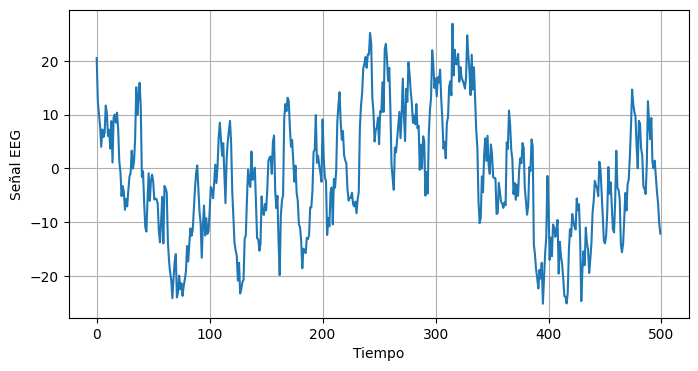

In [11]:
#Se grafica una parte de la señal EEG 
muestra_eeg = datos_eeg[:, 0, 0]  # Extraemos una muestra específica de la señal EEG y la asignamos a la variable muestra_eeg

plt.figure(figsize=(8, 4))  # Creamos una figura con tamaño personalizado (8 pulgadas de ancho, 4 pulgadas de alto)
plt.plot(muestra_eeg)  # Graficamos la muestra de la señal EEG
plt.xlabel('Tiempo')  # Etiqueta del eje x
plt.ylabel('Señal EEG')  # Etiqueta del eje y
plt.grid()  # Mostramos una cuadrícula en el gráfico
plt.show()  # Mostramos el gráfico

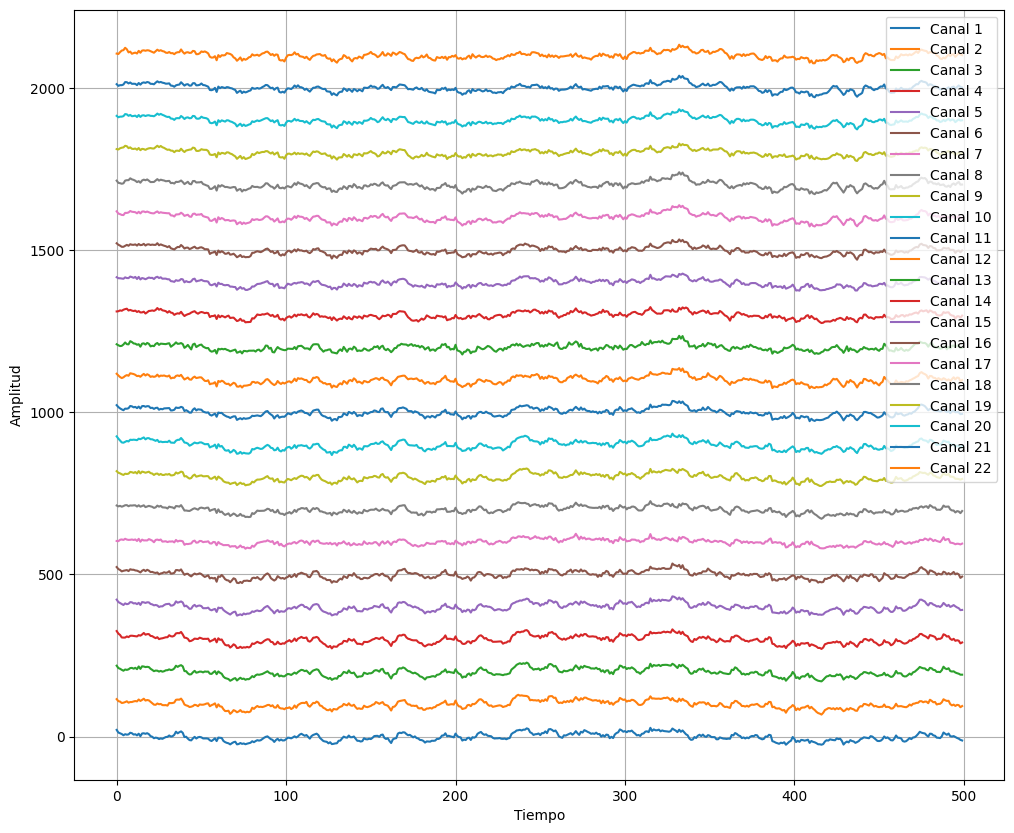

In [21]:
 # Creación del lienzo de visualización
fig, ax = plt.subplots(figsize=(12, 10))  # Creación de la figura y los ejes

# Graficar la cantidad de canales deseados
for canal in range(datos_eeg.shape[1]):
    # Seleccionar la señal del canal actual y agregar un desplazamiento vertical
    canal_data = datos_eeg[:, canal, 0] + canal * 100
    ax.plot(canal_data)

# Configuración de los ejes y la leyenda
ax.set_xlabel('Tiempo')  # Etiqueta del eje x
ax.set_ylabel('Amplitud')  # Etiqueta del eje y
ax.grid(True)  # Mostrar la cuadrícula en el gráfico
ax.legend(['Canal {}'.format(canal + 1) for canal in range(datos_eeg.shape[1])])  # Leyenda con los nombres de los canales

# Mostrar el gráfico
plt.show()


<ipython-input-26-051c42b97ba4>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_canal = plt.figure(figsize=(6, 4))  # Tamaño personalizado para la figura del canal


<Figure size 1000x500 with 0 Axes>

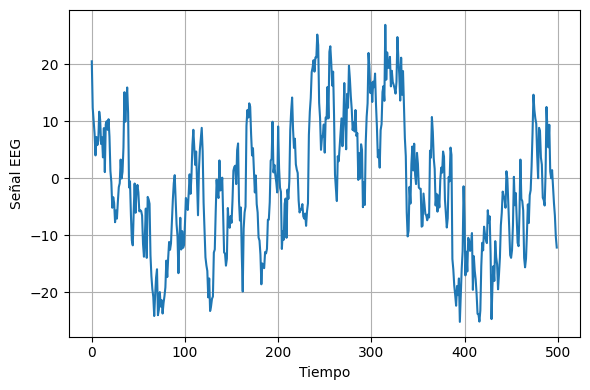

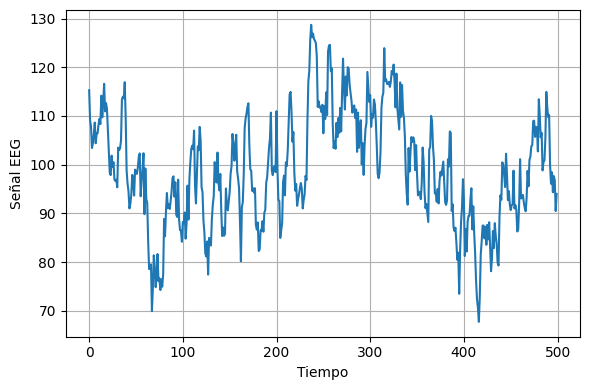

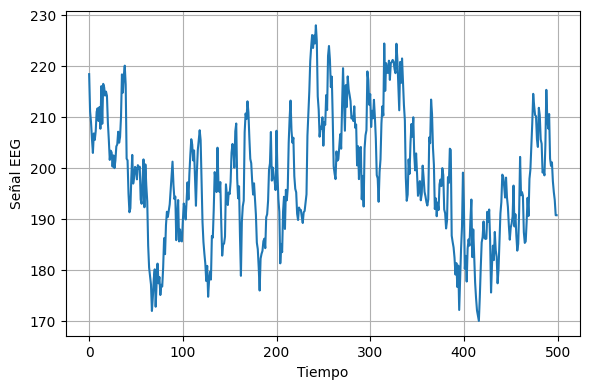

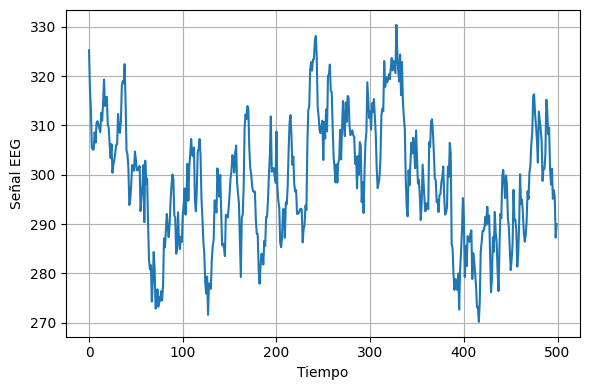

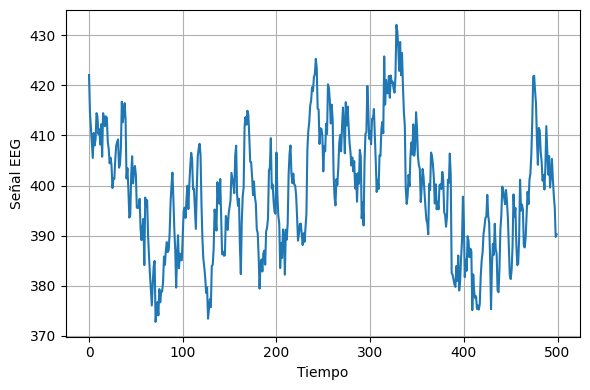

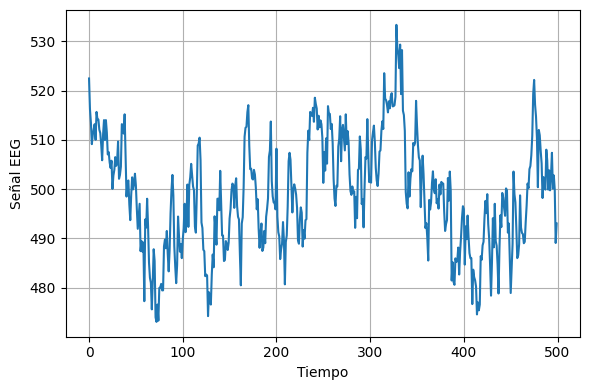

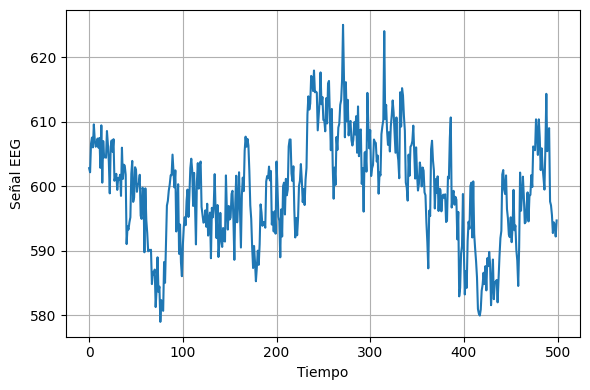

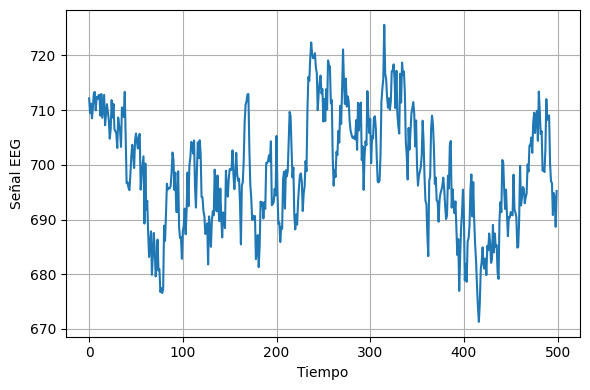

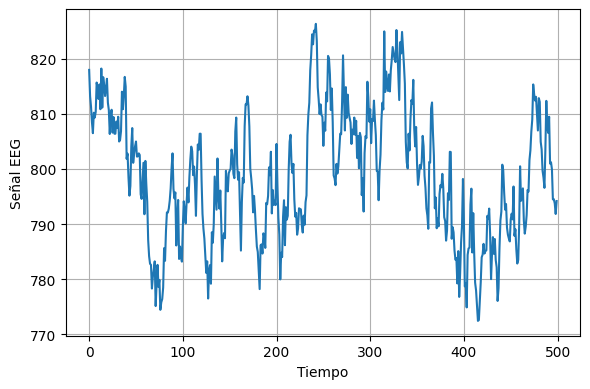

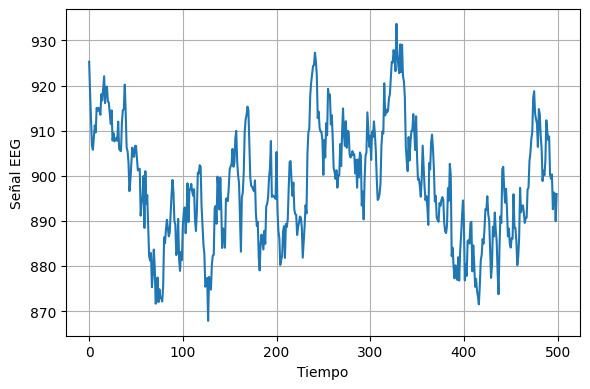

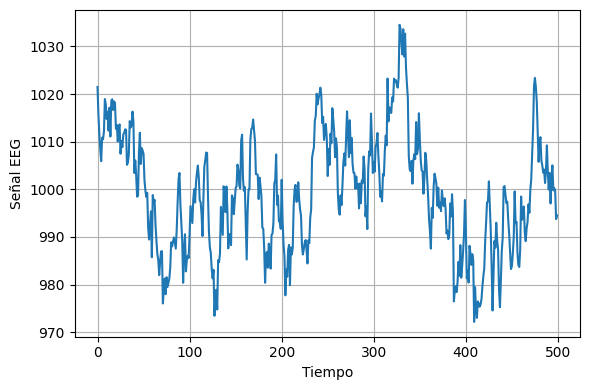

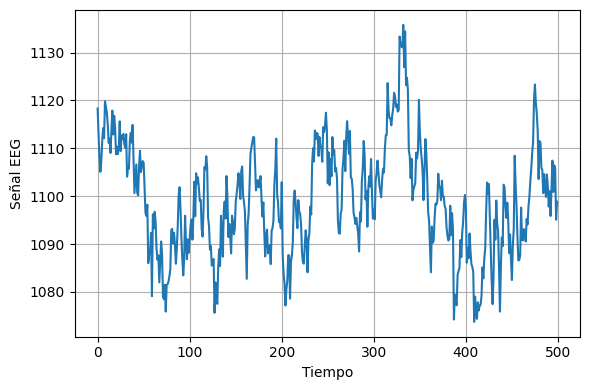

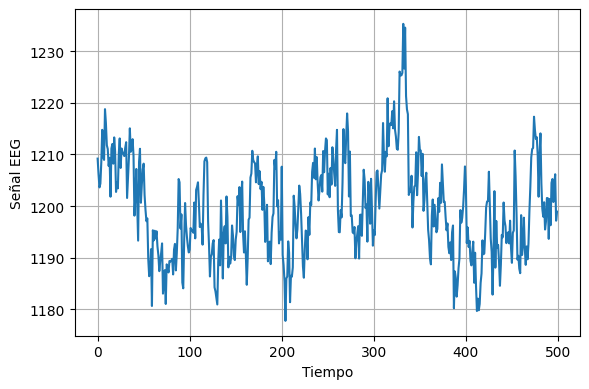

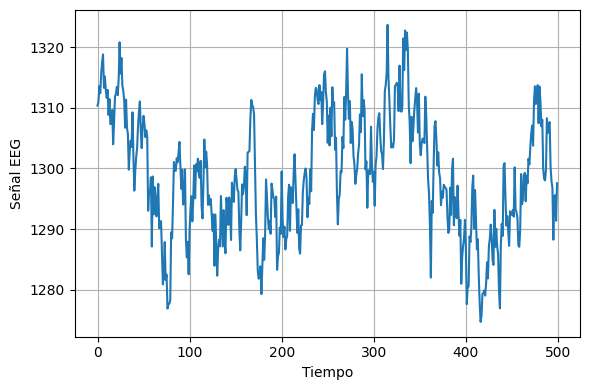

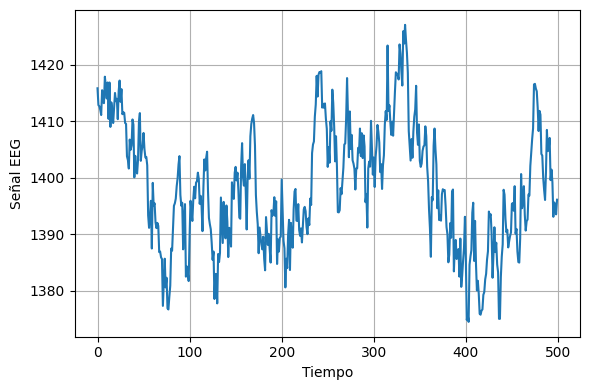

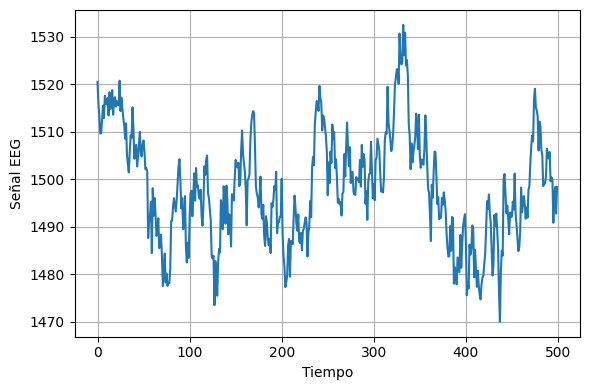

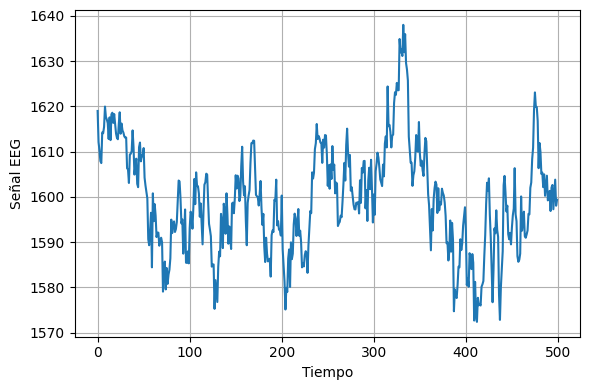

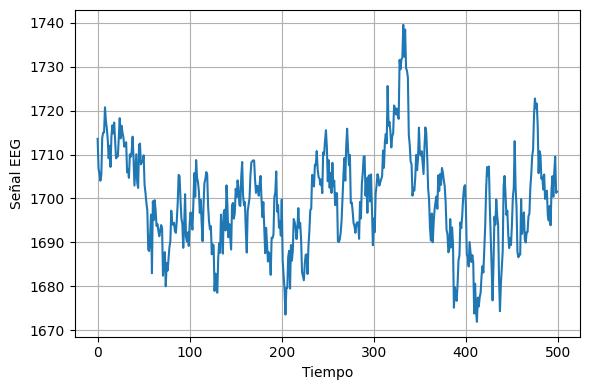

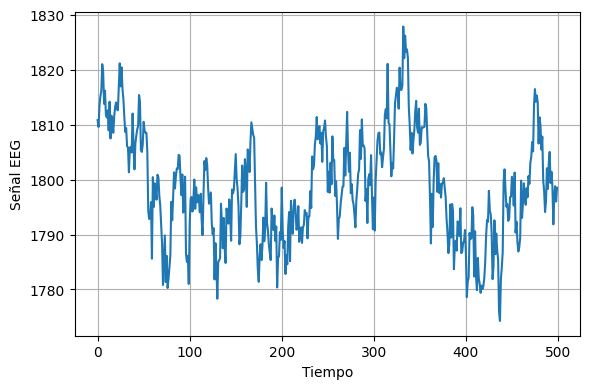

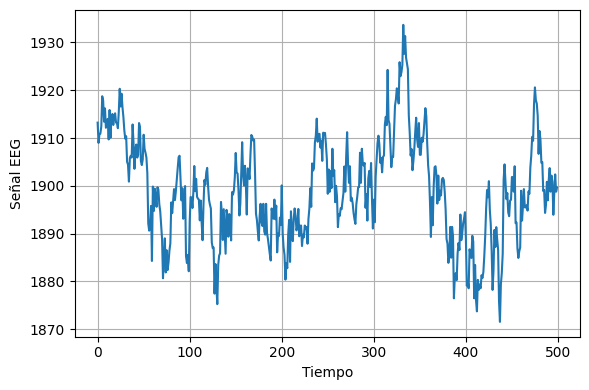

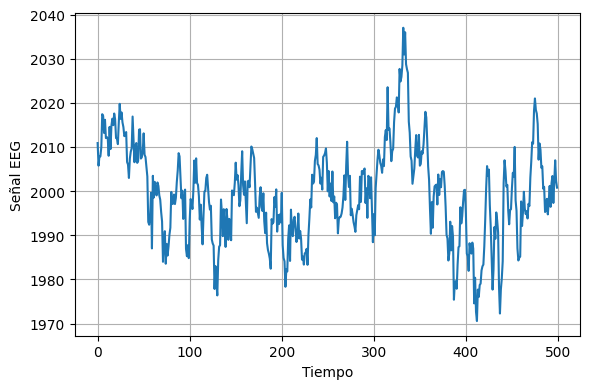

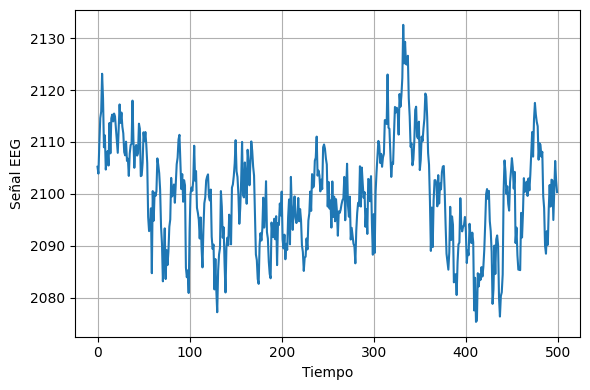

In [26]:
fig_principal = plt.figure(figsize=(10, 5))  # Tamaño personalizado para la figura principal

for canal in range(datos_eeg.shape[1]):  # Iteramos sobre los canales de la señal EEG
    fig_canal = plt.figure(figsize=(6, 4))  # Tamaño personalizado para la figura del canal
    ax_canal = fig_canal.add_subplot(1, 1, 1)  # Añadimos un único subplot a la figura del canal
    
    for epoca in range(int(datos_eeg.shape[2] / 150)):  # Iteramos sobre las épocas de cada canal
        ax_canal.plot(datos_eeg[:, canal, epoca] + canal * 100)  # Graficamos los datos del canal y la época correspondiente
    
    ax_canal.grid(True)  # Activamos la cuadrícula en el gráfico del canal
    ax_canal.set_xlabel('Tiempo')  # Etiqueta del eje x
    ax_canal.set_ylabel('Señal EEG')  # Etiqueta del eje y
    
    plt.tight_layout()  # Ajustamos el espaciado de los subplots para evitar superposiciones
    
plt.show()  # Mostramos la figura principal con los subplots de los canales



In [27]:
# El valor RMS es una medida que captura la amplitud promedio de una señal, considerando tanto los valores positivos como los negativos.
def calcular_valor_rms(senal):
    N = len(senal)  # Número de elementos en la señal
    suma_cuadrados = 0  # Variable para almacenar la suma de los cuadrados de los elementos

    for elemento in senal:  # Iteramos sobre cada elemento de la señal
        suma_cuadrados += elemento ** 2  # Sumamos el cuadrado de cada elemento a la suma total

    valor_rms = np.sqrt(suma_cuadrados / N)  # Calculamos la raíz cuadrada de la media de los cuadrados
    return valor_rms  # Devolvemos el valor RMS calculado


In [35]:
# Creamos un ciclo para procesar las características de la señal para cada uno de los canales.
# El rango del ciclo está determinado por la forma de los datos de entrada.

for canal in range(int(datos_eeg.shape[0] / 40)):

  # Calculamos el promedio de la señal del canal actual y lo redondeamos a 3 decimales.
  promedio = np.round(np.mean(datos_eeg[canal]), 3)

  # Calculamos la desviación estándar de la señal del canal actual y lo redondeamos a 3 decimales.
  desviacion = np.round(np.std(datos_eeg[canal]), 3)

  # Calculamos el valor mínimo de la señal del canal actual y lo redondeamos a 3 decimales.
  minim = np.round(np.min(datos_eeg[canal]), 3)

  # Calculamos el valor máximo de la señal del canal actual y lo redondeamos a 3 decimales.
  maxim = np.round(np.max(datos_eeg[canal]), 3)

  # Calculamos el coeficiente de curtosis de la señal del canal actual (usando la variante de Fisher) y lo redondeamos a 3 decimales.
  kur = np.round(kurtosis(datos_eeg[canal], fisher=True), 3)
       

Proceso de filtrado

In [37]:
#Se cargan los datos
frecuencia_muestreo = 250  # Frecuencia de muestreo de los datos
print('Cargando', archivo, 'con una frecuencia de muestreo de', frecuencia_muestreo, 'Hz.')
datos = sio.loadmat(archivo)  # Cargamos los datos desde el archivo .mat
datos_x = datos['X']  # Extraemos la matriz de datos 'X'
etiquetas = datos['labels'].reshape(-1,)  # Extraemos el vector de etiquetas y lo convertimos en un arreglo unidimensional
indices = np.where((etiquetas == 1) | (etiquetas == 2))[0]  # Obtenemos los índices de los ensayos con etiquetas 1 y 2
datos_x = datos_x[:,:,indices]  # Seleccionamos solo los ensayos correspondientes a las etiquetas 1 y 2
etiquetas = etiquetas[indices]  # Actualizamos las etiquetas solo para los ensayos seleccionados
indices_ordenados = np.argsort(etiquetas)  # Ordenamos los índices en función de las etiquetas

#Filtrado
# Diseñamos un filtro Butterworth pasa banda de orden 5 con frecuencias de corte de 8 Hz y 30 Hz
b, a = butter(5, [8.0 / (0.5 * frecuencia_muestreo), 30.0 / (0.5 * frecuencia_muestreo)], btype='band')
# Aplicamos el filtro a los datos utilizando la función filtfilt para obtener una respuesta de fase lineal
datos_x = filtfilt(b, a, datos_x, axis=0)
# Transponemos los datos para tener la forma de ensayos x canales x tiempo
datos_x = np.transpose(datos_x, (2, 1, 0))


Cargando /content/drive/MyDrive/Dataset_EEG/NEW_22ch_A01.mat con una frecuencia de muestreo de 250 Hz.


Técnicas de separación

In [55]:
#Kurtosis
def KUR(componentes, mezclas, media, n):
    """
    Función para calcular la reconstrucción de datos utilizando componentes independientes (ICs) basada en la kurtosis.

    Parámetros:
    - componentes: Matriz de componentes independientes (ICs).
    - mezclas: Matriz de mezclas correspondiente a las ICs.
    - media: Valor medio utilizado en la reconstrucción.
    - n: Número de componentes a eliminar.

    Retorna:
    - datos_reconstruidos: Datos reconstruidos después de eliminar n componentes con mayor kurtosis.

    """
    kurtosis_r = kurtosis(componentes)  # Calcula la kurtosis de cada IC

    if n >= len(mezclas):
        n = len(mezclas) - 1  # Si n es mayor o igual a la cantidad de componentes, se ajusta para dejar al menos 1 o 2 componentes

    indices_eliminar = np.argsort(kurtosis_r)[:-1 - n]  # Obtiene los índices de los componentes con menor kurtosis (a eliminar)
    componentes_reducidos = componentes[:, indices_eliminar]  # Selecciona solo los componentes correspondientes a los índices obtenidos
    mezclas_reducidas = mezclas[:, indices_eliminar]  # Selecciona solo las mezclas correspondientes a los índices obtenidos

    datos_reconstruidos = np.dot(componentes_reducidos, mezclas_reducidas.T) + media  # Reconstruye los datos eliminando los componentes seleccionados y sumando el valor medio

    return datos_reconstruidos




In [51]:
#ICA
componentes_ica = []
mezclas_ica = []
medias_ica = []

for trial in range(len(datos_x)):
    ica = FastICA(n_components=len(datos_x[0]))
    componentes = ica.fit_transform(datos_x[trial].T)  # Obtener los componentes independientes (ICs)
    mezclas = ica.mixing_  # Obtener la matriz de mezclas estimada
    media = ica.mean_
    
    componentes_ica.append(componentes)
    mezclas_ica.append(mezclas)
    medias_ica.append(media)
    
    # Podemos 'probar' que el modelo de ICA se aplica revirtiendo el proceso de mezcla.
    if not np.allclose(datos_x[trial].T, np.dot(componentes, mezclas.T) + media):
        print('Fallo en la estimación')



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/dec

#Machine learning

In [57]:
# Definir el número de divisiones en validación cruzada
skf = StratifiedKFold(n_splits=5)

resultados_cv1 = []
resultados_cv2 = []
resultados_cv3 = []

# Ciclo para el número de componentes a filtrar
for num_componentes_ica in range(20):
    # Filtrar todos los ensayos usando KUR
    X_filtrado = np.array([KUR(componentes, mezclas, medias, num_componentes_ica) for componentes, mezclas, medias in zip(componentes_ica, mezclas_ica, medias_ica)])
    X_filtrado = np.transpose(X_filtrado, [0, 2, 1])
    
    # Ciclo para el número de componentes en CSP
    for num_componentes_csp in range(2, X_filtrado.shape[1], 2):
        # Ciclo de validación cruzada
        accuracy_lda = []
        accuracy_bayes = []
        accuracy_svm = []
        
        for train_index, val_index in skf.split(etiquetas, etiquetas):
            csp = CSP(n_components=num_componentes_csp).fit(X_filtrado[train_index], etiquetas[train_index])
            features = csp.transform(datos_x)
            
            # Linear Discriminant Analysis (LDA)
            clf_lda = LDA().fit(features[train_index], etiquetas[train_index])
            accuracy_lda.append(clf_lda.score(features[val_index], etiquetas[val_index]))

            # Naive Bayes
            clf_bayes = GaussianNB()
            clf_bayes = clf_bayes.fit(features[train_index], etiquetas[train_index]) 
            accuracy_bayes.append(clf_bayes.score(features[val_index], etiquetas[val_index]))

            # Support Vector Machine (SVM)
            clf_svm = svm.SVC()
            clf_svm = clf_svm.fit(features[train_index], etiquetas[train_index]) 
            accuracy_svm.append(clf_svm.score(features[val_index], etiquetas[val_index]))

        resultados_cv1.append({'num_componentes_ica': num_componentes_ica, 'num_componentes_csp': num_componentes_csp, 'scores': accuracy_lda, 'mean_score': np.mean(accuracy_lda), 'std_score': np.std(accuracy_lda)})
        resultados_cv2.append({'num_componentes_ica': num_componentes_ica, 'num_componentes_csp': num_componentes_csp, 'scores': accuracy_bayes, 'mean_score': np.mean(accuracy_bayes), 'std_score': np.std(accuracy_bayes)})    
        resultados_cv3.append({'num_componentes_ica': num_componentes_ica, 'num_componentes_csp': num_componentes_csp, 'scores': accuracy_svm, 'mean_score': np.mean(accuracy_svm), 'std_score': np.std(accuracy_svm)})


Se han truncado las últimas 5000 líneas del flujo de salida.
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 22 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 22 dim * 2e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 22 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with ran

Visualizar resultados

In [85]:
import pandas as pd

# Crear DataFrame para los resultados de LDA
df_lda = pd.DataFrame(resultados_cv1)
best_lda = df_lda[df_lda['mean_score'] == df_lda['mean_score'].max()]
best_lda['modelo'] = 'LDA'  # Agregar columna 'modelo' con el valor 'LDA'
best_lda.reset_index(drop=True, inplace=True)  # Reiniciar el índice

# Crear DataFrame para los resultados de Naive Bayes
df_bayes = pd.DataFrame(resultados_cv2)
best_bayes = df_bayes[df_bayes['mean_score'] == df_bayes['mean_score'].max()]
best_bayes['modelo'] = 'Naive Bayes'  # Agregar columna 'modelo' con el valor 'Naive Bayes'
best_bayes.reset_index(drop=True, inplace=True)  # Reiniciar el índice

# Crear DataFrame para los resultados de SVM
df_svm = pd.DataFrame(resultados_cv3)
best_svm = df_svm[df_svm['mean_score'] == df_svm['mean_score'].max()]
best_svm['modelo'] = 'SVM'  # Agregar columna 'modelo' con el valor 'SVM'
best_svm.reset_index(drop=True, inplace=True)  # Reiniciar el índice

# Concatenar los tres DataFrames en uno solo
df_final = pd.concat([best_lda, best_bayes, best_svm])

# Reiniciar los índices del DataFrame final
df_final.reset_index(drop=True, inplace=True)

# Imprimir el DataFrame final
df_final




<ipython-input-85-13262cc2e1c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_lda['modelo'] = 'LDA'  # Agregar columna 'modelo' con el valor 'LDA'
<ipython-input-85-13262cc2e1c1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_bayes['modelo'] = 'Naive Bayes'  # Agregar columna 'modelo' con el valor 'Naive Bayes'
<ipython-input-85-13262cc2e1c1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,num_componentes_ica,num_componentes_csp,scores,mean_score,std_score,modelo
0,0,6,"[0.9655172413793104, 0.896551724137931, 0.9310...",0.902463,0.041262,LDA
1,4,14,"[0.8620689655172413, 0.896551724137931, 0.9310...",0.881527,0.037129,Naive Bayes
2,5,10,"[0.896551724137931, 0.896551724137931, 0.93103...",0.881527,0.037129,Naive Bayes
3,5,12,"[0.896551724137931, 0.9655172413793104, 0.9655...",0.930542,0.030858,SVM
